# Introduction to the Assignment 2

## Goal for this Assignment:
* Extend the study to look at the correlation between Astrometric Quantities calculated for the clusters as a whole.
* For example Astrometric Quantities such as:
    * 1-) Parallax
    * 2-) Mean Proper Motion
    * 3-) Cluster Angular Size
    * 4-) Parallax
    * 5-) Proper Motion Velocity Dispersion.

* We first need to import the astropy library and import the fits module from there in order to open the fits files on our code.
* We will also import the libraries we need for the plotting and statistical calculations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
#We import fits module from astropy library.
from astropy.io import fits

In [3]:
#Now we load in our data.
dr3stars = fits.open("gaiadr3_cluster_stars.fits")

#To check the information about the FITS file we have.
#dr3stars.info()

#To check the Column information.
#print(dr3stars[1].columns)

In [4]:
#Now we get our stars using the Pandas library.
import pandas as pd

#Now we assign the table to the Pandas Dataframe as follows.
stars = pd.DataFrame(dr3stars[1].data)

#We strip the white spaces the data has between cluster names in the Name column
#(which are 20 characters long).
stars["Name"] = stars["Name"].str.strip()

#This is our DataFrame straight out of the FITS file.
stars.groupby(["Name"]).size().reset_index(name="count")

,Name,count
0,1636-283,38
1,ADS_16795,41
2,AH03_J0748+26.9,68
3,ASCC_100,87
4,ASCC_101,224
...,...,...
7162,vdBergh_152,25
7163,vdBergh_80,93
7164,vdBergh_83,92
7165,vdBergh_85,105


* **For this assignment we need to create a DataFrame containing only stars with Prob > 0.8.**
* We will use this DataFrame for the rest of the assignment.

In [5]:
#We get the stars that have high probability from the stars DataFrame as 
#follows.
stars_df = stars[stars.Prob > 0.8]

#We define a new clusters DataFrame with High Probability stars only.
#size() counts the number of stars in the clusters, counts how many times
#the name of the cluster is mentioned in the star DataFrame which of course
#tells us how many stars there are in a cluster.
clusters_df = stars_df.groupby(['Name']).size().reset_index(name='count')

#We also add the DataFrame the stars' Standard  Deviations in RA (Right 
#Ascension) and Dec (Declination).
clusters_sd = stars_df.groupby(['Name']).std(numeric_only=True).reset_index()
clusters_df['sd_RAdeg'] = clusters_sd['RAdeg']
clusters_df['sd_DEdeg'] = clusters_sd['DEdeg']

#We print our new Cluster DataFrame
clusters_df

,Name,count,sd_RAdeg,sd_DEdeg
0,1636-283,30,0.038488,0.032713
1,ADS_16795,41,5.028249,2.071391
2,AH03_J0748+26.9,28,0.029759,0.034522
3,ASCC_100,87,0.848365,0.904561
4,ASCC_101,149,0.519560,0.886064
...,...,...,...,...
7162,vdBergh_152,25,0.863601,0.201857
7163,vdBergh_80,93,0.336260,0.260737
7164,vdBergh_83,92,0.283638,0.200000
7165,vdBergh_85,105,0.107164,0.077127


# Task 1:

* Use your Stars DataFrame to calculate the following 6 sample quantities per cluster:
    * 1-) **The number of Stars in the Cluster $n_{*}$.**
    * 2-) **The Mean Parallax $\bar\omega$ of the Stars in the Cluster.**
    * 3-) **The Standard Deviation $\sigma_{\omega}$ of the Parallax of the Stars in the Cluster.**
    * 4-) **The "Size" of the Cluster $\sigma_{pos}$ calculated using the Standard Deviation in RA and Dec Position of the stars.**
    * 5-) **The Mean Proper Motion of the Cluster Stars $\bar\delta$**
    * 6-) **The Standard Deviation of the Proper Motion of the Cluster Stars $\sigma_{\delta}$**
        * Which can be calculated by adding in the Quadrature the RA and Dec Proper Motion Standard Devitations.
        * In other words, the same as for $\sigma_{pos}$.

* To help you do this in Pandas, you can adapt the code you used in Assignment 1:

`clusters_hiprob = stars_hiprob.groupby(['Name']).size().reset_index(name='n_star')`
`clusters_sd_hiprob = stars_hiprob.groupby(['Name']).std(numeric_only=True).reset_index()`

* In here:
    * **`.std`** method calculates the sample standard deviations for all the Numerical Quantities in the stars DataFrame grouped according to the Cluster Name.
    * A similar method exists for the Sample Mean.
    * **Those can then be used to add the Required Columns to the DataFrame with $n_{*}$.**

* Now, select only clusters which satisfy **$n_{*} > 200$** and **$\sigma_{pos} < 1°$**.
* **For these clusters:**
    * 1-) Plot the 5 Astrometric Quantities only (i.e. excluding $n_{*}$) in a scatter-matrix plot.
    * 2-) Compare each pair of quantities and show their histograms.
    * 3-) Comment on whether there are any clear correlations revealed by the scatter plots.

In [6]:
#For this we define a new Pandas DataFrame to store the Astrometric Quantities
#we need for the rest of the assignment.

def cluster_df_for_PM(stars_df, clusters_df):
    """Takes the Stars DataFrame and Clusters DataFrame. Returns a new Cluster
    DataFrame with the Astrometric Quantities:
        1-) Cluster Name ("Cluster Name")
        2-) Number Of Stars in the Cluster ("No of Stars")
        3-) Mean Parallax of the Stars in the cluster ("$\overline{\omega}$")
        4-) Standard Deviation of the Parallax of the Stars in the cluster 
    ("$\sigma_{\omega}$")
        5-) The "Size" of the Cluster calculated from Standard Deviation in the
    RA and Dec Position of the Stars. ("$\sigma_{pos}$")
        6-) The Mean Proper Motion of the Cluster Stars. ("$\overline{\delta}$")
        7-) The Standard Deviation of the Proper Motion of the Cluster Stars.
    ("$\sigma_{\delta}$")
    
    Input:
    ----------------------------------------------------------------------------
    stars_df: Star DataFrame
    clusters_df: Cluster DataFrame
    
    Output:
    ----------------------------------------------------------------------------
    cluster_dataframe: Cluster DataFrame containing the Astrometic Quantities
    listed above.
    
    """
    
    #We first create an empty Pandas DataFrame to store our values.
    cluster_dataframe = pd.DataFrame(columns = ["Cluster Name", "No of Stars", 
                                    "Mean Parallax ($\overline{\omega}$)", 
                                    "Std Parallax ($\sigma_{\omega}$)", 
                                    "Size of Cluster ($\sigma_{pos}$)", 
                                    "Mean Proper Motion ($\overline{\delta}$)", 
                                    "Std Proper Motion ($\sigma_{\delta}$)"])

    #Then, we insert the cluster names and number of stars as follows.
    cluster_dataframe["Cluster Name"] = clusters_df["Name"]
    cluster_dataframe["No of Stars"] =  clusters_df["count"]

    #Then, we calculate the mean parallax for each Cluster as follows.
    cluster_mean = stars_df.groupby(["Name"]).mean(numeric_only=True).reset_index()
    cluster_dataframe["Mean Parallax ($\overline{\omega}$)"] = cluster_mean["Plx"]

    #Then, we calculate the Standard Deviation of Parallax for each Cluster.
    cluster_std = stars_df.groupby(["Name"]).std(numeric_only=True).reset_index()
    cluster_dataframe["Std Parallax ($\sigma_{\omega}$)"] = cluster_std["Plx"]

    #Now, we calculate the "Size" of the cluster by calculating the standard 
    #deviation in RA and Dec position of the stars.
    #For this, we use Size = sqrt(std(RA)^2 + std(Dec)^2) formula.
    #Since we already have them in our DataFrame we can use them right away.
    cluster_dataframe["Size of Cluster ($\sigma_{pos}$)"] = np.sqrt((clusters_df["sd_RAdeg"]**2) + (clusters_df["sd_DEdeg"]**2))

    #For Proper Motion we use the formula Proper Motion = sqrt(pmRA^2 + pmDE^2).
    #Note that we have to find the mean Proper Motion for the stars in the 
    #cluster.
    cl_pm_RA_mean = cluster_mean["pmRA"]
    cl_pm_Dec_mean = cluster_mean["pmDE"]
    cluster_dataframe["Mean Proper Motion ($\overline{\delta}$)"] = np.sqrt((cl_pm_RA_mean**2) + (cl_pm_Dec_mean**2))

    #Now, we calculate the Standard Deviation of the Proper Motion of the 
    #cluster stars.
    #Similar to the Proper Motion Calculation we can use the following formula.
    #Proper Motion Std = sqrt(pmRA_std^2 + pmDE_std^2)
    cl_pm_RA_std = cluster_std["pmRA"]
    cl_pm_Dec_std = cluster_std["pmDE"]
    cluster_dataframe["Std Proper Motion ($\sigma_{\delta}$)"] = np.sqrt((cl_pm_RA_std**2) + (cl_pm_Dec_std**2))
    
    return cluster_dataframe

#We get our new DataFrame.
cluster_dataframe = cluster_df_for_PM(stars_df, clusters_df)

#We "print" the resulting DataFrame.
cluster_dataframe

,Cluster Name,No of Stars,Mean Parallax ($\overline{\omega}$),Std Parallax ($\sigma_{\omega}$),Size of Cluster ($\sigma_{pos}$),Mean Proper Motion ($\overline{\delta}$),Std Proper Motion ($\sigma_{\delta}$)
0,1636-283,30,0.126939,0.034519,0.050512,6.650466,0.240161
1,ADS_16795,41,4.759659,0.101591,5.438194,18.871288,1.810880
2,AH03_J0748+26.9,28,0.210004,0.017010,0.045579,4.025658,0.048521
3,ASCC_100,87,2.748023,0.091920,1.240143,3.863448,0.557090
4,ASCC_101,149,2.517671,0.088908,1.027157,1.595839,0.444430
...,...,...,...,...,...,...,...
7162,vdBergh_152,25,2.674800,0.029313,0.886879,5.349199,0.444215
7163,vdBergh_80,93,1.001419,0.053363,0.425505,3.299538,0.375063
7164,vdBergh_83,92,1.041742,0.095341,0.347059,4.355737,0.277022
7165,vdBergh_85,105,0.539937,0.052169,0.132033,1.035950,0.201852


In [7]:
#Now we have to clean this data.
#The clusters have to satisfy the following:
    #1: No of Stars > 200
    #2: sigma_pos < 1° (Size of the Cluster)
    
#For this we again define a function.
def filtering_cluster_df(cluster_dataframe):
    """Takes the Cluster DataFrame with the Astrometric Quantities. Returns the
    filtered version of it where the clusters have more than 200 stars and their
    size are under 1°.
    
    Input:
    ----------------------------------------------------------------------------
    cluster_dataframe: Cluster DataFrame containing the Astrometic Quantities.
    
    Output:
    ----------------------------------------------------------------------------
    cluster_dataframe_filtered: Cluster DataFrame that only has the clusters
    that have have more than 200 stars and their size are under 1°.
    
    """
    
    #We can filter the DataFrame with one line as follows.
    cluster_dataframe_filtered = cluster_dataframe[
                                (cluster_dataframe["No of Stars"] > 200) & 
                                (cluster_dataframe["Size of Cluster ($\sigma_{pos}$)"] < 1)]
    
    #We also reset the indexes of the clusters as follows.
    cluster_dataframe_filtered = cluster_dataframe_filtered.reset_index(drop = True)
    
    return cluster_dataframe_filtered

#We get our new DataFrame.
cluster_dataframe = filtering_cluster_df(cluster_dataframe)

#We "print" the resulting DataFrame.
cluster_dataframe

,Cluster Name,No of Stars,Mean Parallax ($\overline{\omega}$),Std Parallax ($\sigma_{\omega}$),Size of Cluster ($\sigma_{pos}$),Mean Proper Motion ($\overline{\delta}$),Std Proper Motion ($\sigma_{\delta}$)
0,BH_131,227,0.125637,0.046214,0.221680,6.536827,0.154404
1,BH_140,338,0.190195,0.043486,0.127424,14.897046,0.129645
2,BH_66,355,0.123089,0.044962,0.180838,5.470541,0.229493
3,Berkeley_36,217,0.217359,0.065872,0.063243,1.967901,0.099389
4,Berkeley_39,211,0.226982,0.038289,0.045639,2.371439,0.068647
...,...,...,...,...,...,...,...
193,UBC_461,231,0.298768,0.031775,0.419239,4.096675,0.109858
194,UBC_517,256,0.405671,0.022682,0.716871,5.685520,0.127498
195,UBC_600,390,0.171171,0.039550,0.721515,1.191558,0.134289
196,UFMG_2,212,0.377292,0.026794,0.073233,5.382440,0.102454


In [8]:
#Before we continue, to avoid the code lines being too long we can redefine
#the DataFrame Column Names as follows.
columns_new = ["Cluster Name", "No of Stars", 
               "Mean Parallax", "Std Parallax",
               "Size of Cluster", "Mean Proper Motion",
               "Std Proper Motion"]

cluster_dataframe.columns = columns_new

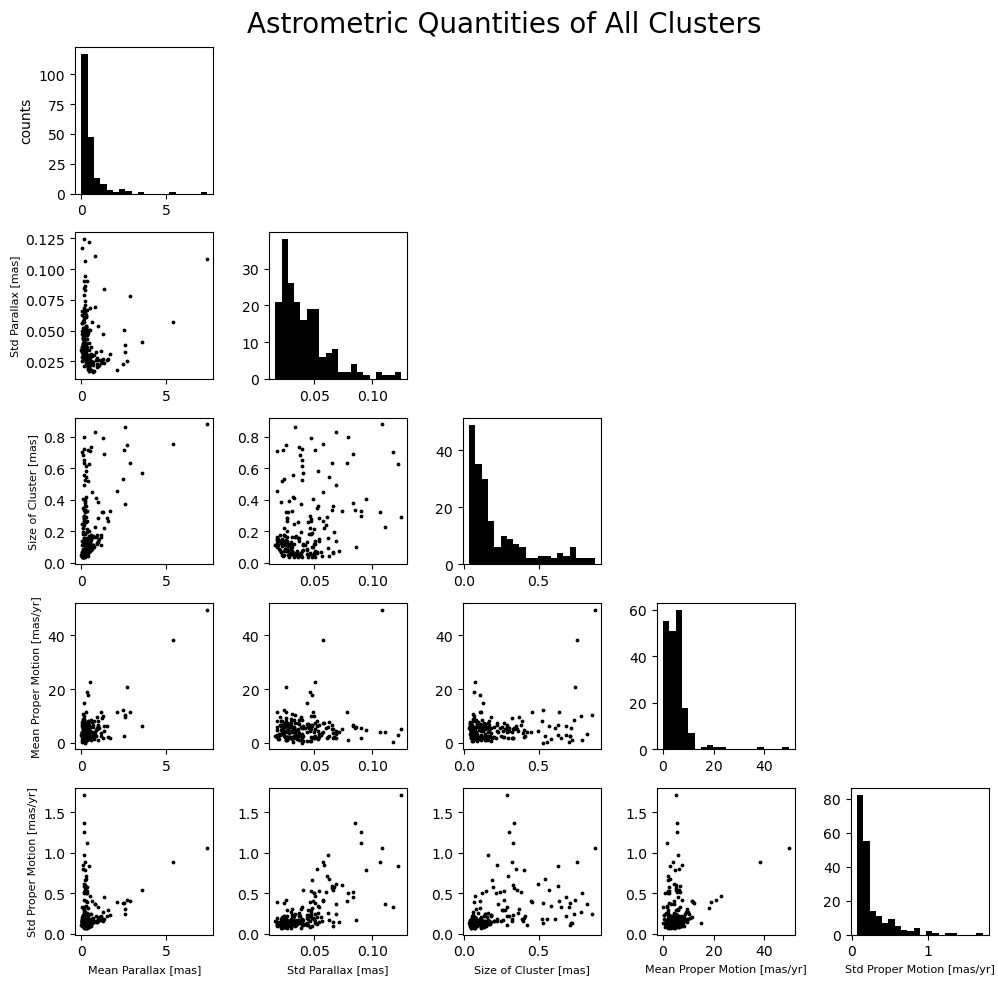

In [9]:
#Now we have to Plot, Compare and Show the Histrograms of the following:
    #1-) Mean Parallax
    #2-) Std Parallax
    #3-) Size of Cluster
    #4-) Mean Proper Motion
    #5-) Std Proper Motion

#For this we define a function as follows. (Most of this is function is copied 
#from the code I wrote for Assignment 1)
def astrometric_quantity_plot(cluster_dataframe):
    """Takes the Cluster DataFrame. Returns the Scatter plots of the astrometric 
    quantities in 5-D Parameter Space alongside their histogram.
    
    Input:
    ----------------------------------------------------------------------------
    cluster_dataframe: Cluster DataFrame containing the Astrometic Quantities.
    
    Output:
    ----------------------------------------------------------------------------
    Scatter Plots & Histograms of the Astrometric Quantities in 5-D Parameter
    Space.
    
    """
    
    #We first define the labels we have, which are the Astrometric Quantities
    #we have on our DataFrame.
    labels = ["Mean Parallax [mas]", "Std Parallax [mas]", "Size of Cluster [mas]", 
              "Mean Proper Motion [mas/yr]", "Std Proper Motion [mas/yr]"]
    
    #Now we horizontally stack all the columns we need by using np.column_stack!
    h_array = np.column_stack((cluster_dataframe["Mean Parallax"],
                               cluster_dataframe["Std Parallax"],
                               cluster_dataframe["Size of Cluster"],
                               cluster_dataframe["Mean Proper Motion"],
                               cluster_dataframe["Std Proper Motion"]))
    
    #Since we will do a 5-D Scatter plot, our dimensions are defined as 5.
    num_dim = 5
    
    #Now we define the figures and the axes as follows.
    figure, axes = plt.subplots(num_dim, num_dim, figsize = (10, 10))
    
    #Now we adjust the figures so that the spacings are as we want.
    figure.subplots_adjust(wspace = 0.25, hspace = 0.35)
    
    #We add a label to our figure.
    figure.suptitle(f"Astrometric Quantities of All Clusters", size = 20)
    
    #Now we do the following to get our plot grid.
    #Note that yellow is for high probability and black is for low probability.
    for i in range(num_dim): #y dimension of the grid.
        for j in range(num_dim): #x dimension of the grid
            if i == j: #For (0,0), (1,1), (2,2) etc.
                axes[i, j].hist(h_array[ : , i], bins = 20, color = "black")
                
        
            elif i > j: #For (0,1), (0,2), ... ,(1,2), ...
                axes[i, j].scatter(h_array[ : , j], h_array[ : , i], s = 3, c = "black")
        
            else:
                axes[i, j].axis("off")
        
            if j == 0: #For (0,1), (0,2) ...
                if i == j:
                    axes[i, j].set_ylabel("counts", fontsize = 10)
            
                else:
                    axes[i, j].set_ylabel(labels[i], fontsize = 8)
        
            if i == (num_dim - 1):
                axes[i, j].set_xlabel(labels[j], fontsize = 8)
    
    #To prevent plots clipping through one another we do the following.
    plt.tight_layout()

    #We show our plot.
    plt.show()

#We get our plots using the function.
astrometric_quantity_plot(cluster_dataframe)

## Comments:
* **First of all let's discuss how the correlations show themselves in plots:**
    * 1-) **If there is an upwards Slope on the data (from left to right):** 
        * There is a **positive correlation!**
    * 2-) **If there is a downwards Slope on the data (from left to right):**
        * There is a **negative correlation!**
    * 3-) **If there is no Slope on the data:**
        * There is **no apparent correlation!**
    * 4-) **If the data is concentrated on a line:**
        * There is a **strong correlation!**
    * 5-) **If the data is spread out along a line:**
        * There is a **weak correlation!**

* **On our plots, by the first look we can say the following:**
    * There seems to be **no correlation** between Std Parallax - Mean Parallax, Size of Cluster - Mean Parallax, Mean Proper Motion - Std Parallax, Mean Proper Motion - Size of Cluster.
    * As for the rest of the graphs (in general), **there could be a correlation** since some of the plots seem to follow an upward line which suggests a positive correlation.
    * Some of the graphs also show some sort of a correlation but the data is mostly concentrated on a straight line.
    * For this reason, the Correlation Coefficients we will calculate on the next task are vital to see if there is a correlation or not.

# Task 2:

## Correlation Tests:

### a-)
* **Now search for correlations by each of the combinations shown in the scatter-matrix plots by:**
    * 1-) **Calculating the Pearson and Spearman correlation coefficients.**
    * 2-) **Calculating the Pearson and Spearman p-values**

* Comment on whether the tests are appropriate given the observed distributions of the measured quantities.

In [10]:
#For the Correlation Tests, we import two modules from scipy.stats as follows.
from scipy.stats import pearsonr, spearmanr

## Assumptions:
* 1-) **Data is uncorrelated.**
    * This is our **Null Hypothesis!**
    * **If the p-value is smaller than 0.05, this would mean that the Data we are analysing is actually statistically correlated with each other.**
* 2-) **Data is Independent and Identically Distributed (I.I.D).**
    * **Independent**: Data is uncorrelated.
    * **Identically Distributed:** Data is from the same Distribution.
    * **The measured significance of a Correlation significantly depends on this assumption!!!**
* 3-) **Data sample must be large.**
    * This is due to the Central Limit Theorem.

### Before we continue, let's talk about how to interpret the results we get from the Correlation Tests.

### 1-) Correlation Coefficients:
* **It shows how strong the correlation is between two variables we are comparing**.
* **If the Correlation Coefficient Value is**:
    * 1-) **<ins>Close to 1**: **Strong Positive Correlation.** (If far from 1, it would of course mean a weaker correlation)
        * As the variable increases, the other variable also increases.
    * 2-) **<ins>Close to -1**: **Strong Negative Correlation.** (If far from -1, it would of course mean a weaker correlation)
        * As the variable increases, the other variable decreases.
    * 3-) **<ins>Close to 0**: **No Correlation**
        * The variables are increasing and decreasing independently.

### 2-) p-values:
* **It shows the significance/accuracy of the Correlation Coefficient we have obtained.**
* **It is very similar to the Accepting or Rejecting the Null Hypothesis by looking at the p-values, like we have done on Assignment 1.**
* **If the p-value is:**
    * 1-) **<ins>Small (less than 0.05)**: **Correlation is significant.**
    * 2-) **<ins>Large (more than 0.05)**: **Correlation has appeared by random chance** (There is no evidence that statistically shows the correlation is significant)

* **Spearman's Test:** 
    * Looks at the ranking of the data points!
    * It is insenstive to the data values!

In [11]:
#Now we need to find the Pearson and Spearman:
    #1-) Correlation Coefficients
    #2-) p-values

#We need to find them for each scatter plot we have done for Task 1.
#For this, we will again define a function.
def corr_coeff_calc(cluster_dataframe):
    """Takes the Cluster DataFrame. Does the Pearson and Spearman Correlation 
    Tests and returns a DataFrame that contains the Correlation Coefficients and
    p-values from the Correlation Tests, alongside the information about the
    test results.
    
    Input:
    ----------------------------------------------------------------------------
    cluster_dataframe: Cluster DataFrame containing the Astrometic Quantities.
    
    Output:
    ----------------------------------------------------------------------------
    corr_results: DataFrame that contains all of the parameters we have compared
    with their Correlation Coefficient and P-Values from Pearson and Spearman
    Correlation Tests. The DataFrame also contains information on whether the
    parameters have a correlation or not and how significant the correlation is.
    
    """
    #First of all, let's create an empty Pandas DataFrame.
    corr_results = pd.DataFrame(columns = ["Compared Parameters", 
                                            "Pearson Corr Coeff",
                                            "Pearson p-value",
                                            "Pearson Test Result",
                                            "Spearman Corr Coeff",
                                            "Spearman p-value",
                                            "Spearman Test Result"])
    
    #In this function we'll use another method to create a new Pandas DataFrame.
    #First of all, we define a list to store our Correlation Test Results.
    test_results = []
    
    #We now define the Astrometric Parameters that are in our DataFrame.
    labels = ["Mean Parallax", "Std Parallax", "Size of Cluster", 
              "Mean Proper Motion", "Std Proper Motion"]
    
    #We first horizontally stack all the columns we need by using np.column_stack!
    h_array = np.column_stack((cluster_dataframe["Mean Parallax"],
                               cluster_dataframe["Std Parallax"],
                               cluster_dataframe["Size of Cluster"],
                               cluster_dataframe["Mean Proper Motion"],
                               cluster_dataframe["Std Proper Motion"]))
    
    #Just like on the plotting, we'll again use slicing.
    #We again define the number of dimensions/parameters.
    num_dim = 5
    
    #Now we do a loop like we did it in plotting.
    #But this time, we'll get the Correlation Coefficients and p-values instead.
    for i in range(num_dim): #y dimension
        for j in range(num_dim): #x dimension
            #First, we have to do the tests.
            #For these tests, we'll have to skip the cases where i = j since
            #those correspond to histograms.
            #We do it with the following "if" statement.
            if i >= j:
                continue
            
            #We get our datasets i.e. our Astrometric Quantities.
            dataset_1 = h_array[ : , j]
            dataset_2 = h_array[ : , i]
                
            #Now we do our Correlation Tests.
            
            ############################## PEARSON TEST ##############################
            
            #We do the Pearson Correlation Test.
            pearson_corr_value, pearson_p_value = pearsonr(dataset_1, dataset_2)
            
            #We also comment on whether this result corresponds to a correlation
            #or not.
            #We have talked about this before this block of code so we just
            #write what we have discussed.
            
            #For Correlation Value:
            if pearson_corr_value >= 0.5:
                result_pearson_1 = "Strong Positive Correlation"
            
            elif 0 < pearson_corr_value < 0.5:
                result_pearson_1 = "Weak Positive Correlation"
            
            elif abs(pearson_corr_value) <= 0.09  or pearson_corr_value == 0:
                result_pearson_1 = "No Correlation"
            
            elif -0.5 < pearson_corr_value < 0:
                result_pearson_1 = "Weak Negative Correlation"
            
            elif pearson_corr_value <= -0.5:
                result_pearson_1 = "Strong Negative Correlation"
            
            #For p-value:
            if pearson_p_value <= 0.05:
                result_pearson_2 = "Statistically Significant"
            
            else:
                result_pearson_2 = "Statistically Not Significant"
            
            #Now we get our result.
            result_pearson = f"{result_pearson_1}, " \
                             f"{result_pearson_2}."
            
            ############################## SPEARMAN TEST #############################
            #We do the Spearman Correlation Test.
            spearman_corr_value, spearman_p_value = spearmanr(dataset_1, dataset_2)
            
            #We also comment on whether this result corresponds to a correlation
            #or not.
            #We have talked about this before this block of code so we just
            #write what we have discussed.
            
            #For Correlation Value:
            if spearman_corr_value >= 0.5:
                result_spearman_1 = "Strong Positive Correlation"
            
            elif 0 < spearman_corr_value < 0.5:
                result_spearman_1 = "Weak Positive Correlation"
            
            elif abs(spearman_corr_value) <= 0.09 or spearman_corr_value == 0:
                result_spearman_1 = "No Correlation"
            
            elif -0.5 < spearman_corr_value < 0:
                result_spearman_1 = "Weak Negative Correlation"
            
            elif spearman_corr_value <= -0.5:
                result_spearman_1 = "Strong Negative Correlation"
            
            #For p-value:
            if spearman_p_value <= 0.05:
                result_spearman_2 = "Statistically Significant"
            
            else:
                result_spearman_2 = "Statistically Not Significant"
            
            #Now we get our result.
            result_spearman = f"{result_spearman_1}, " \
                              f"{result_spearman_2}."
            
            #Second, we have to get the parameters we are comparing.
            parameter_1 = labels[i]
            parameter_2 = labels[j]
            
            #Now we add everything to our list.
            test_results.append({"Compared Parameters" : f"{parameter_1} vs {parameter_2}",
                                 "Pearson Corr Coeff" : pearson_corr_value,
                                 "Pearson p-value" : pearson_p_value,
                                 "Pearson Test Result": result_pearson,
                                 "Spearman Corr Coeff": spearman_corr_value,
                                 "Spearman p-value": spearman_p_value,
                                 "Spearman Test Result" : result_spearman})
    
    #Now we create a DataFrame using the test_results list as follows.
    corr_results = pd.DataFrame(test_results)
    
    return corr_results

#Now we'll show our results.
#To get the full sentences in "Pearson Test Result" & "Spearman Test Result"
#We do the following to expand the maximum column width.
pd.set_option('display.max_colwidth', None)

#Now we get our results.
corr_coeff_calc(cluster_dataframe)

,Compared Parameters,Pearson Corr Coeff,Pearson p-value,Pearson Test Result,Spearman Corr Coeff,Spearman p-value,Spearman Test Result
0,Mean Parallax vs Std Parallax,0.047611,5.053547e-01,"Weak Positive Correlation, Statistically Not Significant.",-0.376186,4.712017e-08,"Weak Negative Correlation, Statistically Significant."
1,Mean Parallax vs Size of Cluster,0.476555,1.275929e-12,"Weak Positive Correlation, Statistically Significant.",0.373636,5.897056e-08,"Weak Positive Correlation, Statistically Significant."
2,Mean Parallax vs Mean Proper Motion,0.668548,5.222066e-27,"Strong Positive Correlation, Statistically Significant.",0.051292,4.729721e-01,"Weak Positive Correlation, Statistically Not Significant."
3,Mean Parallax vs Std Proper Motion,0.228468,1.206247e-03,"Weak Positive Correlation, Statistically Significant.",0.025229,7.242273e-01,"Weak Positive Correlation, Statistically Not Significant."
4,Std Parallax vs Size of Cluster,0.341305,8.621712e-07,"Weak Positive Correlation, Statistically Significant.",0.208774,3.160198e-03,"Weak Positive Correlation, Statistically Significant."
5,Std Parallax vs Mean Proper Motion,0.129134,6.980531e-02,"Weak Positive Correlation, Statistically Not Significant.",-0.013398,8.513929e-01,"No Correlation, Statistically Not Significant."
6,Std Parallax vs Std Proper Motion,0.713024,4.760937e-32,"Strong Positive Correlation, Statistically Significant.",0.604036,4.484188e-21,"Strong Positive Correlation, Statistically Significant."
7,Size of Cluster vs Mean Proper Motion,0.236015,8.156744e-04,"Weak Positive Correlation, Statistically Significant.",-0.005288,9.410603e-01,"No Correlation, Statistically Not Significant."
8,Size of Cluster vs Std Proper Motion,0.403202,3.872148e-09,"Weak Positive Correlation, Statistically Significant.",0.554065,2.508930e-17,"Strong Positive Correlation, Statistically Significant."
9,Mean Proper Motion vs Std Proper Motion,0.264974,1.615733e-04,"Weak Positive Correlation, Statistically Significant.",0.153248,3.112366e-02,"Weak Positive Correlation, Statistically Significant."


## Comments:
* The comments about the results we get from the Correlation Tests are given at the DataFrame above.

### b-)

* You can improve the situation by performing the tests on log-transformed data (i.e. **on the logarithm of the quantities, instead of the original values**)
* Why should this make the tests more reliable?
* Finally, comment on your results and their implications.

In [12]:
#Now we are gonna do the same thing but this time we take the logarithm of the
#Astrometric Parameters we have.
#For this we can define a new DataFrame that is a copy of our normal one, that
#contains the logarithm values of the Astrometric Quantities we have.
cluster_dataframe_log = cluster_dataframe.copy()

#Now we define the columns/astrometric parameters that we want to take the
#logarithm of.
column_log = ["Mean Parallax", "Std Parallax", "Size of Cluster", 
              "Mean Proper Motion", "Std Proper Motion"]

#Now we take their logarithm.
cluster_dataframe_log[column_log] = np.log10(cluster_dataframe_log[column_log])

#Now we put it into our Correlation Test function we have defined on Task 2a.
corr_coeff_calc(cluster_dataframe_log)

,Compared Parameters,Pearson Corr Coeff,Pearson p-value,Pearson Test Result,Spearman Corr Coeff,Spearman p-value,Spearman Test Result
0,Mean Parallax vs Std Parallax,-0.252036,3.409650e-04,"Weak Negative Correlation, Statistically Significant.",-0.376186,4.712017e-08,"Weak Negative Correlation, Statistically Significant."
1,Mean Parallax vs Size of Cluster,0.428522,3.012242e-10,"Weak Positive Correlation, Statistically Significant.",0.373636,5.897056e-08,"Weak Positive Correlation, Statistically Significant."
2,Mean Parallax vs Mean Proper Motion,0.196391,5.553836e-03,"Weak Positive Correlation, Statistically Significant.",0.051292,4.729721e-01,"Weak Positive Correlation, Statistically Not Significant."
3,Mean Parallax vs Std Proper Motion,0.111445,1.180250e-01,"Weak Positive Correlation, Statistically Not Significant.",0.025229,7.242273e-01,"Weak Positive Correlation, Statistically Not Significant."
4,Std Parallax vs Size of Cluster,0.264515,1.660300e-04,"Weak Positive Correlation, Statistically Significant.",0.208774,3.160198e-03,"Weak Positive Correlation, Statistically Significant."
5,Std Parallax vs Mean Proper Motion,-0.002964,9.669425e-01,"No Correlation, Statistically Not Significant.",-0.013398,8.513929e-01,"No Correlation, Statistically Not Significant."
6,Std Parallax vs Std Proper Motion,0.673524,1.576212e-27,"Strong Positive Correlation, Statistically Significant.",0.604036,4.484188e-21,"Strong Positive Correlation, Statistically Significant."
7,Size of Cluster vs Mean Proper Motion,-0.027338,7.022286e-01,"No Correlation, Statistically Not Significant.",-0.005288,9.410603e-01,"No Correlation, Statistically Not Significant."
8,Size of Cluster vs Std Proper Motion,0.557149,1.535025e-17,"Strong Positive Correlation, Statistically Significant.",0.554065,2.508930e-17,"Strong Positive Correlation, Statistically Significant."
9,Mean Proper Motion vs Std Proper Motion,0.169528,1.695536e-02,"Weak Positive Correlation, Statistically Significant.",0.153248,3.112366e-02,"Weak Positive Correlation, Statistically Significant."


In [13]:
#We now set the maximum column width back to its original setting.
pd.reset_option("all")

## Comments:
* The comments about the results we get from the Correlation Tests are given at the DataFrame above.

* **Why should taking the logarithm of the data make the tests more reliable?**
    * **In log-log plots:**
        * 1-) Any power relation between two variables show up linear.
        * 2-) Data points are evenly spaced.
    * **In normal/linear plots:** 
        * 1-) The power relations would, of course, show as a curve.
        * 2-) Data points are compressed at the low end.
            * **We can see that from our previous plot at Task 1.**
            * The scatter plots we had showed that the data is mostly accumulated at one corner.
            * As for the log-log scatter plots (**see the figure below**) we see that the data is actually distributed evenly.
            * **As a result, this is a much easier way to see the correlations that might exist between two variables.**
            * **It also, of course, changes the Correlation Test results as well.**
            * **For example:**
                * **The Spearman's Test cares about the ranks of the Data Points.**
                * **The ranks of the points change in log-log plots compared to the Normal/Linear Plotting.**
                * **As a result, our test results also change.**

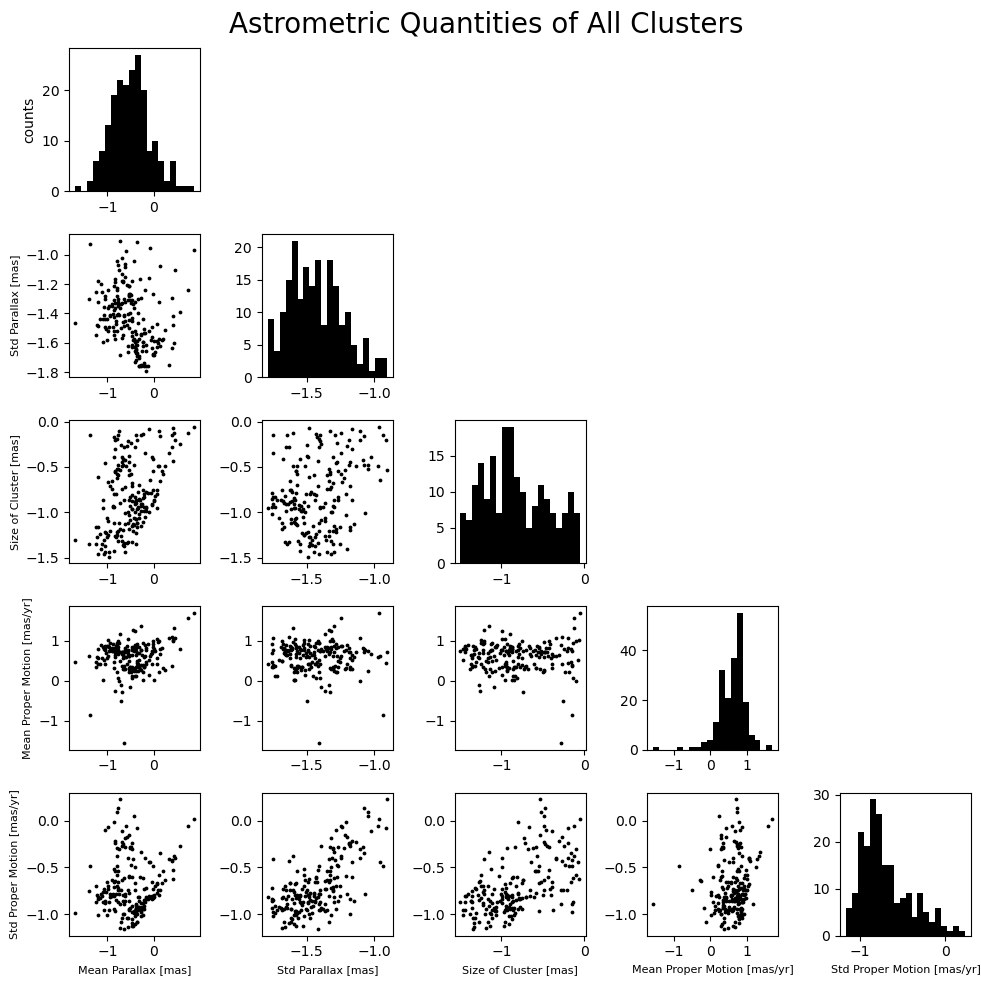

In [14]:
astrometric_quantity_plot(cluster_dataframe_log)

# Task 3:

* Now randomly select a cluster from the sample used in Task 2.
* **Using the parallaxes of the individual stars in the cluster:**
    * **Use Bayes' Theorem to calculate the Posterior PDF for distance $d$ (in kpc) to cluster.**
    * **Use the formula $d = 1/p$ to find the distance where $p$ is parallax in milliarcsec (mas)**

* **Gaia has a known "zero-point" offset - a systematic error - in parallax!**
* **So before you do your calculation, you should first add a correction of 0.029 mas to the parallax measurements!**

* **You should calculate the Posterior PDF for two different Prior PDFs:**
    * a-) **A Uniform Prior PDF**
    * b-) **A more Realistic PDF corresponding to constant Volume Density modified by an exponential decrease with distance:**
    $$p(d) ∝ d^{2}e^{-d/L}$$
        Where the Length-Scale **L = 1 kpc**.

* **You may assume that the corrected parallax measurements are:**
    * **Normally Distributed** about **True Parallax**.
    * **Standard Deviation** is given by the **errors on the Parallax Measurements.**

* **For each prior:**
    * **Calculate the distance corresponding to the Mode (Maximum) of the Posterior PDF.**
    * **Plot your Posterior PDF (on the same plot for both priors)**
    * **Determine the 1-$\sigma$ Confidence Interval on the distance.**
    * **Indicate the Mode and Interval on your PDF.**
    * **On the same plot**:
        * **Compare the Bayesian Posterior PDFs with the PDF you obtain by just assuming the Normal Distribution with:**
            * **Mean obtained by:** Inverting the Mean Parallax for the cluster $\bar\omega$ **to obtain $d$**.
            * **Standard Deviation obtained by:** Propagating the standard error on $\bar\omega$ **to obtain the Standard Deviation on $d$**.

* Finally:
    * **Repeat the analysis above using just 10 stars from the cluster to see the effect of smaller numbers.**
    * You should pick a random sub-sample to get the 10 stars.

* **Hint for fast Numerical Calculation:**
    * To output a Pandas Data Column to a numpy array which you can reshape as needed, use the `.values` method.

## Assumptions:
* 1-) **Causes and Events are independent.**
* 2-) **Prior Probability of event $A$ is known.** (Prior PDF!)
* 3-) **$P(B) ≠ 0$** (**So the Marginal Likelihood can not be zero in the Bayesian Formula!**)
* 4-) **$A$ and $B$ are conditionally independent of one another.** (Stated in assumption 1 as well.)
* 5-) **The probability of observing the outcome for every possible cause is known.**

In [15]:
#First we need to randomly select a cluster and get the stars in that cluster.
#For this we again define a function.
def random_sample_cluster(cluster_dataframe, stars_df):
    """Takes the Cluster DataFrame. Returns the Star DataFrame of a Randomly 
    selected/sampled cluster.
    
    Input:
    ----------------------------------------------------------------------------
    cluster_dataframe: Cluster DataFrame containing the Astrometic Quantities.
    star_df: Star DataFrame containing all the stars in our FITS data.
    
    Output:
    ----------------------------------------------------------------------------
    cluster_sample_df: DataFrame that contains stars inside the randomly 
    selected cluster.
    
    """
    
    #We randomly select a cluster from our DataFrame.
    cl_sample = cluster_dataframe.sample(n = 1)
    
    #We change the name of "Column Name" to "Name" so that we can merge the
    #DataFrames.
    cl_sample = cl_sample.rename(columns = {"Cluster Name" : "Name"})
    
    #Now we get the stars inside of that cluster.
    #For this we first get the name of the cluster.
    cluster_name = cl_sample.iloc[0,0]
    
    #Now we find the rows that have the cluster's name in the stars DataFrame.
    rows = stars_df[stars_df["Name"] == cluster_name]
    
    #We merge both DataFrames based on the "Name" column as follows.
    cluster_sample_df = pd.merge(rows, cl_sample, on = "Name", how = "inner")
    
    return cluster_sample_df

#We get our Cluster & Star Sample as follows.
sample_star_df = random_sample_cluster(cluster_dataframe, stars_df)

#We print our resulting DataFrame.
sample_star_df

,Name,ID,GaiaDR3,inrt,Prob,RAdeg,e_RAdeg,DEdeg,e_DEdeg,GLON,...,o_Vbroad,VarFlag,NSS,RVS,No of Stars,Mean Parallax,Std Parallax,Size of Cluster,Mean Proper Motion,Std Proper Motion
0,Ruprecht_112,5282,5874485297750801664,1,1.000000,224.146183,0.031968,-62.519494,0.038411,316.817490,...,0.0,NOT_AVAILABLE,0,0,216,0.346764,0.024412,0.133987,6.132496,0.087398
1,Ruprecht_112,5282,5874485022872854016,1,0.890412,224.161723,0.013240,-62.537389,0.017119,316.815557,...,0.0,NOT_AVAILABLE,0,0,216,0.346764,0.024412,0.133987,6.132496,0.087398
2,Ruprecht_112,5282,5874485057232798464,1,1.000000,224.197080,0.064128,-62.534621,0.077475,316.831313,...,0.0,NOT_AVAILABLE,0,0,216,0.346764,0.024412,0.133987,6.132496,0.087398
3,Ruprecht_112,5282,5874485057232798592,1,0.806161,224.196693,0.056558,-62.533333,0.068585,316.831752,...,0.0,NOT_AVAILABLE,0,0,216,0.346764,0.024412,0.133987,6.132496,0.087398
4,Ruprecht_112,5282,5874485091592343936,1,0.837867,224.156166,0.048407,-62.531599,0.058711,316.815967,...,0.0,NOT_AVAILABLE,0,0,216,0.346764,0.024412,0.133987,6.132496,0.087398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Ruprecht_112,5282,5874480521746932608,1,1.000000,224.486222,0.019391,-62.584321,0.023596,316.926250,...,0.0,NOT_AVAILABLE,0,0,216,0.346764,0.024412,0.133987,6.132496,0.087398
212,Ruprecht_112,5282,5874480556107056768,1,0.937379,224.450981,0.032529,-62.574202,0.043076,316.916614,...,0.0,NOT_AVAILABLE,0,0,216,0.346764,0.024412,0.133987,6.132496,0.087398
213,Ruprecht_112,5282,5874480762270184576,1,1.000000,224.348841,0.013718,-62.612440,0.016401,316.857100,...,0.0,NOT_AVAILABLE,0,0,216,0.346764,0.024412,0.133987,6.132496,0.087398
214,Ruprecht_112,5282,5874480796624834944,1,0.867380,224.387057,0.029993,-62.603314,0.036449,316.876941,...,0.0,NOT_AVAILABLE,0,0,216,0.346764,0.024412,0.133987,6.132496,0.087398


* Now let's briefly talk about the Bayes' Theorem.

$$P(H\vert D) = \frac{P(D\vert H)P(H)}{P(D)}$$

* $P(H\vert D)$: **Posterior Probability/The Posterior**
    * The term we want to know.
    * Gives the Posterior Probability of the parameter $H$ given the data $D$.
* $P(D\vert H)$: **Likelihood**
    * It is the likelihood of obtaining the data, given our hypothesis.
* $P(H)$: **Prior Probability/The Prior**
    * Our Prior Knowledge or Belief about whether the given hypothesis is likely or not.
    * It represents what we consider plausible parameter values.
* $P(D)$: **Evidence**
    * A normalization constant.
    * A term corresponding to the probability of obtaining the given data, regardless of obtaining the given data.
    * **This term can be calculated by marginalising over the possible parameter values and whatever viable, alternate hypotheses can account for the data.**

* **In our case**:
    * **Distance ($d$):** The parameter we have.
    * **Parallax ($p$):** The data we have.
    * $P(Distance\vert Parallax)$: Posterior PDF for Distance values, given the parallax.
    * $P(Parallax\vert Distance)$: Likelihood of the Parallax value, given the Distance.
    * $P(Distance)$: Prior PDF for the Distance.
    * $P(Parallax)$: Marginal Likelihood.

In [16]:
#First we need to randomly select a cluster and get the stars in that cluster.
#For this we again define a function.
def random_sample_cluster(cluster_dataframe, stars_df):
    """Takes the Cluster DataFrame. Returns the Star DataFrame of a Randomly 
    selected/sampled cluster.
    
    Input:
    ----------------------------------------------------------------------------
    cluster_dataframe: Cluster DataFrame containing the Astrometic Quantities.
    star_df: Star DataFrame containing all the stars in our FITS data.
    
    Output:
    ----------------------------------------------------------------------------
    cluster_sample_df: DataFrame that contains stars inside the randomly 
    selected cluster.
    
    """
    
    #To select a Cluster Name...
    #cluster_dataframe = cluster_dataframe[cluster_dataframe["Cluster Name"] == "HSC_2138"]
    
    #We randomly select a cluster from our DataFrame.
    cl_sample = cluster_dataframe.sample(n = 1)
    
    #We change the name of "Column Name" to "Name" so that we can merge the
    #DataFrames.
    cl_sample = cl_sample.rename(columns = {"Cluster Name" : "Name"})
    
    #Now we get the stars inside of that cluster.
    #For this we first get the name of the cluster.
    cluster_name = cl_sample.iloc[0,0]
    
    #Now we find the rows that have the cluster's name in the stars DataFrame.
    rows = stars_df[stars_df["Name"] == cluster_name]
    
    #We merge both DataFrames based on the "Name" column as follows.
    cluster_sample_df = pd.merge(rows, cl_sample, on = "Name", how = "inner")
    
    return cluster_sample_df

#We get our Cluster & Star Sample as follows.
sample_star_df = random_sample_cluster(cluster_dataframe, stars_df)

#We print our resulting DataFrame.
sample_star_df

,Name,ID,GaiaDR3,inrt,Prob,RAdeg,e_RAdeg,DEdeg,e_DEdeg,GLON,...,o_Vbroad,VarFlag,NSS,RVS,No of Stars,Mean Parallax,Std Parallax,Size of Cluster,Mean Proper Motion,Std Proper Motion
0,Melotte_66,4425,5507234429619600512,1,0.942502,111.601735,0.030480,-47.672017,0.031288,259.565975,...,0.0,NOT_AVAILABLE,0,0,208,0.190451,0.020872,0.065888,3.117296,0.071459
1,Melotte_66,4425,5507234395259864448,1,0.814730,111.586448,0.028387,-47.696219,0.028040,259.584179,...,0.0,NOT_AVAILABLE,0,0,208,0.190451,0.020872,0.065888,3.117296,0.071459
2,Melotte_66,4425,5507234395259864320,1,0.965124,111.593713,0.039911,-47.688854,0.039711,259.579400,...,0.0,NOT_AVAILABLE,0,0,208,0.190451,0.020872,0.065888,3.117296,0.071459
3,Melotte_66,4425,5507234395259861120,1,0.905801,111.591693,0.030552,-47.678027,0.029937,259.568673,...,0.0,NOT_AVAILABLE,0,0,208,0.190451,0.020872,0.065888,3.117296,0.071459
4,Melotte_66,4425,5507234429619601792,1,0.985489,111.597419,0.046061,-47.681226,0.045495,259.573339,...,0.0,NOT_AVAILABLE,0,0,208,0.190451,0.020872,0.065888,3.117296,0.071459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Melotte_66,4425,5507210618320884608,1,0.862355,111.463237,0.016161,-47.742230,0.017043,259.591454,...,0.0,NOT_AVAILABLE,0,0,208,0.190451,0.020872,0.065888,3.117296,0.071459
204,Melotte_66,4425,5507210446522200448,1,0.810550,111.492070,0.065301,-47.733833,0.063789,259.591956,...,0.0,NOT_AVAILABLE,0,0,208,0.190451,0.020872,0.065888,3.117296,0.071459
205,Melotte_66,4425,5507022430033016832,1,0.923622,111.502612,0.030095,-47.787011,0.032803,259.644868,...,0.0,NOT_AVAILABLE,0,0,208,0.190451,0.020872,0.065888,3.117296,0.071459
206,Melotte_66,4425,5507022597534862208,1,0.813687,111.481684,0.089960,-47.783429,0.094868,259.635436,...,0.0,NOT_AVAILABLE,0,0,208,0.190451,0.020872,0.065888,3.117296,0.071459


In [17]:
#We import norm module from the scipy.stats library since the Parallax data is
#normally distributed.
from scipy.stats import norm

#Now we define a function to get the Posterior PDF for distance values.
#Our goal is to find the distance to the cluster itself.
def Posterior_PDF(sample_star_df, prior_dist = "uniform"):
    """Takes the Star DataFrame and the Prior Distribution. Calculates the
    distances of the stars by using the parallax formula. Then, calculates
    the Likelihood, Prior PDF and Marginal Likelihood in order to find the
    Posterior PDF. Returns the Posterior PDF and Distance Interval we have
    defined. Also returns the Normal Distribution PDF.
    
    Input:
    ----------------------------------------------------------------------------
    sample_star_df: Star DataFrame containing the stars inside of the cluster
    we have randomly sampled.
    
    Output:
    ----------------------------------------------------------------------------
    posterior_pdf: Numpy Array containing the Posterior PDF values we have
    calculated.
    distance_interval: Numpy Array containing the Distance Interval we have
    defined for the calculation of the PDF.
    
    """
    
    #We first get our Parallax Data and the Parallax Errors as follows.
    #We also turn the DataFrames containing our Data and Errors into numpy 
    #arrays by using np.asarray(), which will help us with our calculations.
        #Note: We are adding "0.029 mas" due to the "Zero-Point" Offset error.
        #Note: Our Parallax Errors are our Standard Deviations for the Parallax
    #values.
    
    parallax_data = np.asarray(sample_star_df["Plx"] + 0.029)
    parallax_data_errors = np.asarray(sample_star_df["e_Plx"])
    
    #We find the distances of the stars as follows.
    #Note that the results from now on will be numpy arrays, instead of a Pandas
    #DataFrame.
    distance_data = 1/parallax_data
    
    #Now we find the Mean and the Standard Deviation of our Distance Data
    #since we will need it to define a Distance interval to calculate the
    #likelihood and marginalizing!
    distance_mean = np.mean(distance_data)
    distance_std = np.std(distance_data)
    
    #Now we define our Distance interval as follows.
    #distance_interval = np.linspace(distance_mean - (distance_mean/4),
                                    #distance_mean + (distance_mean/4),
                                    #1000)
    
    distance_interval = np.linspace(distance_mean - (5 * distance_std),
                                    distance_mean + (5 * distance_std),
                                    1000)
    
    #We also define an Error interval as follows.
    err_interval = np.linspace(min(parallax_data_errors),
                               max(parallax_data_errors),
                               1000)
    
    #We can also define a Parallax interval by simply using the formula.
    parallax_interval = 1 / distance_interval
    
    ################ LIKELIHOOD OF THE PARALLAX, GIVEN DISTANCE ###############
    
    #Since the "corrected parallax measurements are Normally Distributed about 
    #True Parallax." we use the scipy.stats norm module to find the likelihood
    #as follows.
    #Note that we use np.reshape() in order to change our array into an array
    #that has a "column". For example: (300,) => (300, 1)
    #In here:
        #norm.pdf: Probability Density Function of Normal Distribution.
        #loc: Mean of the Distribution => Our Parallax Interval
        #scale: Standard Deviation of the Distribution => Our Parallax Errors
    #("Standard Deviation is given by the errors on the Parallax Measurements.")
    likelihood_values = np.prod(
                        norm.pdf(parallax_data.reshape(len(parallax_data),1), 
                                loc = parallax_interval,
                                scale = parallax_data_errors.reshape(len(parallax_data_errors),1)), 
                        axis = 0)
    
    ########################## PRIOR PDF FOR DISTANCE #########################
    
    #Now we define our Prior PDFs for distance.
    #For this we are given two options.
    #First Prior PDF, the Uniform Distribution:
    if prior_dist == "uniform":
        prior_pdf = 1 / (np.max(distance_interval) - np.min(distance_interval))
    
    #Second Prior PDF, the "Realistic Distribution"
    elif prior_dist == "realistic":
        L = 1
        prior_pdf = (distance_interval ** 2) * np.exp(-distance_interval / L)
    
    #Third Prior PDF, the Normal Distribution (Only for plotting)
    elif prior_dist == "normal":
        prior_pdf = norm.pdf(distance_interval, 
                             loc = 1/np.mean(parallax_data),
                             scale = np.mean(parallax_data_errors)/(np.mean(parallax_data)**2))
    
    ############################ MARGINAL LIKELIHOOD ##########################
    
    #Now we need to integrate all the likelihood values we have obtained from
    #the likelihood_values.
    #For the integration we use "np.trapz".
    #Note that we have to use axis = 0 in order to integrate over all the rows
    #so basically all the star data. (The reason why we used np.reshape() to
    #reshape our array previously.)
    marginal_likelihood = np.trapz(likelihood_values * prior_pdf, distance_interval, axis = 0)
    
    ################# POSTERIOR PDF FOR DISTANCE, GIVEN PARALLAX ##############
    
    #Now we calculate the Posterior PDF as follows.
    posterior_pdf = (likelihood_values * prior_pdf) / marginal_likelihood
    
    ################### GETTING THE DISTANCE OF THE CLUSTER ###################
    #Now using the PDF, we get the distance to our cluster.
    
    #np.argmax() will give us the index of the Mode so the maximum "probability 
    #density" of our PDF, then we use that index on the distance_interval to 
    #find the distance to our cluster.
    
    mode_cluster_distance = distance_interval[np.argmax(posterior_pdf)]
    
    return posterior_pdf, distance_interval, mode_cluster_distance

<IPython.core.display.Javascript object>


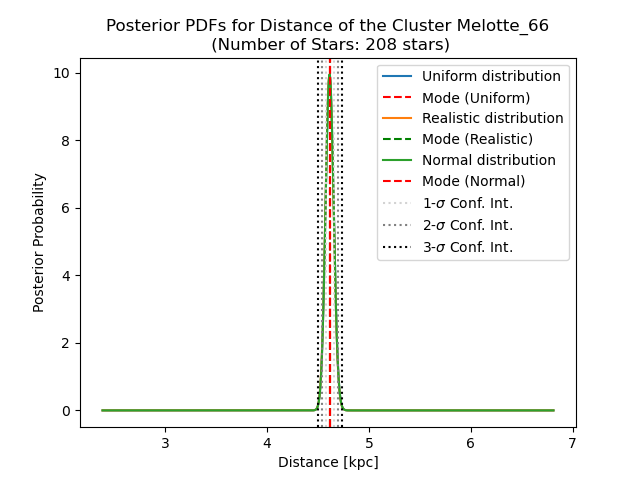

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Prior Distribution: Uniform Distribution
------------------------------------------------------------
The Posterior PDF has been found using 208 stars.
The Cluster Melotte_66 is 4.614 kpc away.
The 1-𝜎 Confidence Interval is: 4.5751 kpc - 4.6551 kpc.
The 2-𝜎 Confidence Interval is: 4.5372 kpc - 4.695 kpc.
The 3-𝜎 Confidence Interval is: 4.4984 kpc - 4.7373 kpc.
------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Prior Distribution: Realistic Distribution
------------------------------------------------------------
The Posterior PDF has been found using 208 stars.
The Cluster Melotte_66 is 4.614 kpc away.
The 1-𝜎 Confidence Interval is: 4.5742 kpc - 4.6541 kpc.
The 2-𝜎 Confidence Interval is: 4.5363 kpc - 4.6939 kpc.
The 3-𝜎 Confidence Interval is: 4.4974 kpc - 4.7363 kpc.
------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~

In [29]:
#We import scipy for some of the following integrations.
import scipy

#We also make our plots interactive.
%matplotlib notebook

#Now we define a separate function for the plotting.
def plotting_posterior_pdf(sample_star_df):
    """Takes the Star DataFrame. Returns the Plots of the Posterior PDFs for
    different Prior PDFs (Uniform and Realistic). Also prints out additional
    information about the Current Prior PDF, Cluster Name and Confidence Int-
    ervals 1-𝜎, 2-𝜎 and 3-𝜎.
    
    Input:
    ----------------------------------------------------------------------------
    sample_star_df: Star DataFrame containing the stars inside of the cluster
    we have randomly sampled.
    
    Output:
    ----------------------------------------------------------------------------
    posterior_pdf: Numpy Array containing the Posterior PDF values we have
    calculated.
    distance_interval: Numpy Array containing the Distance Interval we have
    defined for the calculation of the PDF.
    
    Note:
    ----------------------------------------------------------------------------
    The plotted Confidence Intervals are for the "Realistic" Prior PDF. The
    function does not plot the Confidence Intervals for other Prior PDFs to
    avoid confusion.
    
    """
    
    #We first obtain the name of our current cluster as follows.
    cluster_name = sample_star_df.iloc[0, 0]
    
    #We also obtain the number of stars in our cluster as follows.
    star_no = sample_star_df.shape[0]
    
    #We define the prior PDFs we have.
    prior_dist_list = ["uniform", "realistic", "normal"]
    
    #We create our figure for plotting.
    plt.figure()
    
    #Now we use our previous function for both prior distributions we have and
    #print the results.
    for prior_dist in prior_dist_list:
        posterior_pdf, distance_interval, mode_cluster_distance = Posterior_PDF(sample_star_df, prior_dist=prior_dist)
        
        print(60 * "~")
        print(f"Prior Distribution: {prior_dist.capitalize()} Distribution")
        
        print(60 * "-")
        print(f"The Posterior PDF has been found using {star_no} stars.")
        print(f"The Cluster {cluster_name} is {round(mode_cluster_distance, 4)} kpc away.")
        
        #To find the confidence intervals we have to first find the Posterior 
        #CDF (Cumulative Density Function), then the Posterior PPF (Percent
        #Point Function).
        posterior_cdf = scipy.integrate.cumulative_trapezoid(posterior_pdf, distance_interval, initial = 0)
        posterior_ppf = scipy.interpolate.interp1d(posterior_cdf, distance_interval)
        
        #Now we calculate the following Confidence Intervals:
            #1-𝜎 : 68%
            #2-𝜎 : 95%
            #3-𝜎 : 99%
        one_sigma = posterior_ppf([0.16, 0.84])
        two_sigma = posterior_ppf([0.025, 0.975])
        three_sigma = posterior_ppf([0.0015, 0.9985])
        
        #We print the results.
        print(f"The 1-𝜎 Confidence Interval is: {round(one_sigma[0], 4)} kpc - {round(one_sigma[1], 4)} kpc.")
        print(f"The 2-𝜎 Confidence Interval is: {round(two_sigma[0], 4)} kpc - {round(two_sigma[1], 4)} kpc.")
        print(f"The 3-𝜎 Confidence Interval is: {round(three_sigma[0], 4)} kpc - {round(three_sigma[1], 4)} kpc.")
        print(60 * "-")
        
        #Now we plot our results for the current prior distribution in our loop.
        plt.plot(distance_interval, posterior_pdf, "-", label = f"{prior_dist.capitalize()} distribution")
        
        #We also plot the Mode of our current prior distribution in our loop.
        color_mode = "red"
        if prior_dist == "realistic":
            color_mode = "green"
        
        plt.axvline(x = mode_cluster_distance, color = color_mode, linestyle = "--", label = f"Mode ({prior_dist.capitalize()})")
      
    #We plot the Title and the Labels.
    plt.title(f"Posterior PDFs for Distance of the Cluster {cluster_name}\n (Number of Stars: {star_no} stars)")
    plt.xlabel("Distance [kpc]")
    plt.ylabel("Posterior Probability")
    
    #We plot the Confidence Intervals.
    plt.axvline(x = round(one_sigma[0], 4), color = "lightgray", linestyle = "dotted", label = "1-$\sigma$ Conf. Int.")
    plt.axvline(x = round(one_sigma[1], 4), color = "lightgray", linestyle = "dotted")
    
    plt.axvline(x = round(two_sigma[0], 4), color = "gray", linestyle = "dotted", label = "2-$\sigma$ Conf. Int.")
    plt.axvline(x = round(two_sigma[1], 4), color = "gray", linestyle = "dotted")
    
    plt.axvline(x = round(three_sigma[0], 4), color = "black", linestyle = "dotted", label = "3-$\sigma$ Conf. Int.")
    plt.axvline(x = round(three_sigma[1], 4), color = "black", linestyle = "dotted")
    
    plt.legend()
    
    plt.show()

plotting_posterior_pdf(sample_star_df)

<IPython.core.display.Javascript object>


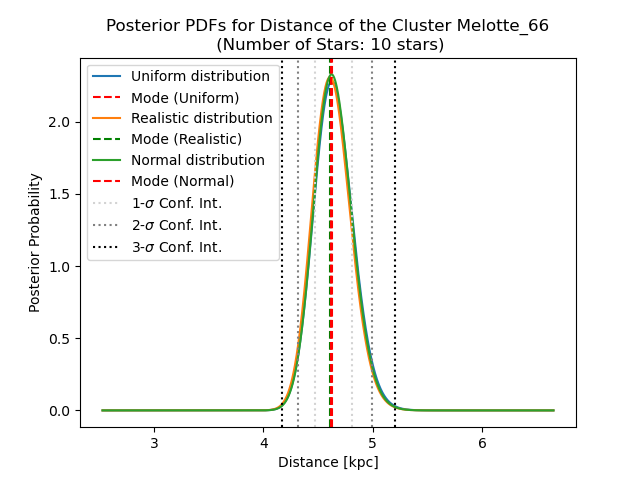

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Prior Distribution: Uniform Distribution
------------------------------------------------------------
The Posterior PDF has been found using 10 stars.
The Cluster Melotte_66 is 4.6271 kpc away.
The 1-𝜎 Confidence Interval is: 4.472 kpc - 4.8216 kpc.
The 2-𝜎 Confidence Interval is: 4.3199 kpc - 5.0118 kpc.
The 3-𝜎 Confidence Interval is: 4.1718 kpc - 5.2271 kpc.
------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Prior Distribution: Realistic Distribution
------------------------------------------------------------
The Posterior PDF has been found using 10 stars.
The Cluster Melotte_66 is 4.6106 kpc away.
The 1-𝜎 Confidence Interval is: 4.4566 kpc - 4.8019 kpc.
The 2-𝜎 Confidence Interval is: 4.3063 kpc - 4.9894 kpc.
The 3-𝜎 Confidence Interval is: 4.1597 kpc - 5.2013 kpc.
------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~

In [30]:
#Now we sample 10 random stars from our Cluster.
random_stars = sample_star_df.sample(n = 10)

#We plot it to see the difference between large amounts of data vs small amounts
#of data.
plotting_posterior_pdf(random_stars)

In [31]:
#From here the plots will go back to noninteractive ones.
%matplotlib inline

## Comments:


* One noticeable thing is that when the **data count** is lower, the Posterior PDF **becomes wider!**
* This is expected since with less data, **the probability of the Mode** (which is our "true" distance) **will also be lower.**
* More Data means clearer results, that's why when the **data/star count** is higher we get a much more sharper peak at our mode.
* Note that also with **high data/star count** the Posterior Probability is much higher at our mode, compared to when our data count is lower.

* As for the different Prior PDFs one thing we can see is that all of the PDFs are more or less intersecting with one another.
* However, even though not shown in the plots, **their confidence intervals are different!**
* **Their Modes are also different, hence the different distances we get from our results!**

## Problems with the code:
* **Some of the clusters have problems when plotting their PDFs.**
* **The cause of it is about the "Realistic Distribution" where the results from the Normal and Uniform Distribution do not match with the Realistic Distribution for some of the Clusters.**
* **The reason for this problem is probably related to the distance interval, since the problem was slightly solved when I defined another interval but wasn't sure of it so I left it as it is.**
* **An example of the Problem I am encountering:** (Not an accurate example, just to show how the problem looks)
    * Uniform Distribution: The Cluster is 4.6271 kpc away.
    * Normal Distribution: The Cluster is 4.6271 kpc away.
    * Realistic Distribution: The Cluster is **-150.2234 kpc** away.
        * This only happens to a few of the clusters.

# Task 4:

* Now repeat the Bayesian Distance Calculation for all Clusters used in the Correlation Sample in Task 2.
* **For this we use only the more Realistic, constant density exponentially decreasing prior!**
* You should  **obtain the Distance estimate for each cluster from the Maximum Posterior Probability of d!**

* **Then, use your distances to correct these 4 Observed Quantities to the values they would have at a fixed distance of 1 kpc:**
    * 1-) **The Standard Deviation $\sigma_{\omega}$ of the Parallax of the Stars in the Cluster.**
    * 2-) **The "Size" of the Cluster $\sigma_{pos}$ calculated using the Standard Deviation in RA and Dec Position of the stars.**
    * 3-) **The Mean Proper Motion of the Cluster Stars $\bar\delta$**
    * 4-) **The Standard Deviation of the Proper Motion of the Cluster Stars $\sigma_{\delta}$**

* **For these 4 corrected quantities:**
    * **Show the Scatter-Matrix plot.**
    * **Perform Pearson and Spearman Correlation Tests.**

* **After the results:**
    * Comment on your results.
    * Comment on how they differ compared to what we have obtained in Task 1 and Task 2 for the same quantities.

## Assumptions:
* Same as Task 2 and Task 3 assumptions.

In [21]:
#First of all we need to repeat the Bayesian Distance Calculation for all the
#Clusters.
def bayesian_dist_calc(cluster_dataframe, stars_df):
    """Takes the Cluster and Star DataFrame. Checks every single Cluster Name,
    finds all the stars in individual cluster and uses the Bayesian Distance
    Calculation to find the distance to each cluster.
    
    Input:
    ----------------------------------------------------------------------------
    cluster_dataframe: Cluster DataFrame.
    stars_df: Stars DataFrame.
    
    Output:
    ----------------------------------------------------------------------------
    dist_df: DataFrame containing the Cluster Name, the Number of Stars inside
    that cluster and the Distance to the Cluster in kpc.
    
    """
    
    #We first define a list to store the results we get.
    result_list = []
    
    #Now we get all of the names from our Cluster DataFrame using .unique().
    cluster_names = cluster_dataframe["Cluster Name"].unique()
    
    #Now we check every name, get the stars that are in that cluster, then do
    #the Bayesian Calculation, get the distance and add it to our distance
    #dataframe as follows.
    for name in cluster_names:
        #We get the stars.
        star_rows = stars_df[stars_df["Name"] == name]
        
        #We do the Bayesian Distance Calculation.
        #Note that we have to use the Realistic Distribution since the task
        #stated that.
        posterior_pdf, distance_interval, mode_cluster_distance = Posterior_PDF(star_rows, prior_dist = "realistic")
        
        #Now we add everything to result list.
        result_list.append({"Cluster Name" : name,
                            "No of Stars" : star_rows.shape[0],
                            "Distance (kpc)" : mode_cluster_distance})
    
    #Now we convert our result list (that has dictionaries in it with our 
    #results for each loop we did over the cluster names) into a DataFrame.
    dist_df = pd.DataFrame(result_list)
    
    return dist_df

#We get our Distance DataFrame as follows.
dist_df = bayesian_dist_calc(cluster_dataframe, stars_df)

#We print the DataFrame.
dist_df

C:\Users\kayah\AppData\Local\Temp\ipykernel_2572\2356797565.py:95: RuntimeWarning: overflow encountered in exp
  prior_pdf = (distance_interval ** 2) * np.exp(-distance_interval / L)
C:\Users\kayah\AppData\Local\Temp\ipykernel_2572\2356797565.py:95: RuntimeWarning: overflow encountered in multiply
  prior_pdf = (distance_interval ** 2) * np.exp(-distance_interval / L)
C:\Users\kayah\AppData\Local\Temp\ipykernel_2572\2356797565.py:116: RuntimeWarning: invalid value encountered in divide
  posterior_pdf = (likelihood_values * prior_pdf) / marginal_likelihood
C:\Users\kayah\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kayah\AppData\Local\Temp\ipykernel_2572\2356797565.py:111: RuntimeWarning: invalid value encountered in multiply
  marginal_likelihood = np.trapz(likelihood_values * prior_pdf, distance_interval, axis = 0)
C:\Users\kayah\AppData\Local\Temp\ipykernel

,Cluster Name,No of Stars,Distance (kpc)
0,BH_131,227,6.431236
1,BH_140,338,4.637932
2,BH_66,355,6.572051
3,Berkeley_36,217,4.072760
4,Berkeley_39,211,3.980008
...,...,...,...
193,UBC_461,231,2.998289
194,UBC_517,256,2.290470
195,UBC_600,390,4.819210
196,UFMG_2,212,2.490396


In [22]:
#Now we need to correct some of our Astrometric Quantities.
#For this, we can use our old DataFrame from Task 1, that contains the
#Astrometric Quantities and put them into the following function.
def dist_correction(cluster_dataframe, dist_df):
    """Takes the Cluster and Distance DataFrame. Returns the DataFrame with the
    corrected values of our Astrometric Quantities.
    
    Input:
    ----------------------------------------------------------------------------
    cluster_dataframe: Cluster DataFrame.
    dist_df: Cluster DataFrame that only contains the distances.
    
    Output:
    ----------------------------------------------------------------------------
    cluster_df_correction: DataFrame containing the corrected values of our
    Astrometric Quantities.
    
    """
    
    #We get our DataFrame.
    cluster_df_correction = cluster_dataframe
    
    #We first remove the Astrometric Quantities that we won't use.
    cluster_df_correction = cluster_df_correction.drop(columns = ["No of Stars", "Mean Parallax"])
    
    #We add the distances as a column to our DataFrame.
    cluster_df_correction["Distance"] = dist_df["Distance (kpc)"]
    
    ########################## DISTANCE CORRECTION ############################
    #Now we have to correct all of the Astrometric Quantities as follows.
    
    #For Standard Deviation of the Parallax of the Stars in the Cluster:
    cluster_df_correction["Std Parallax"] = cluster_df_correction["Std Parallax"] * cluster_df_correction["Distance"]
    
    #For the "Size" of the Cluster:
    cluster_df_correction["Size of Cluster"] = cluster_df_correction["Size of Cluster"] * cluster_df_correction["Distance"]
    
    #For the Mean Proper Motion of the Cluster Stars:
        #We do not need to correct it since it is independent of the distance.
    cluster_df_correction["Mean Proper Motion"] = cluster_df_correction["Mean Proper Motion"]
        
    #For the Standard Deviation of the Proper Motion of the Cluster Stars:
    cluster_df_correction["Std Proper Motion"] = cluster_df_correction["Std Proper Motion"] * cluster_df_correction["Distance"]
    
    return cluster_df_correction

#We get the distance corrected DataFrame.
cluster_dataframe_corrected = dist_correction(cluster_dataframe, dist_df)

#We print the DataFrame.
cluster_dataframe_corrected

,Cluster Name,Std Parallax,Size of Cluster,Mean Proper Motion,Std Proper Motion,Distance
0,BH_131,0.297210,1.425674,6.536827,0.993011,6.431236
1,BH_140,0.201687,0.590982,14.897046,0.601286,4.637932
2,BH_66,0.295495,1.188475,5.470541,1.508242,6.572051
3,Berkeley_36,0.268280,0.257572,1.967901,0.404786,4.072760
4,Berkeley_39,0.152390,0.181644,2.371439,0.273217,3.980008
...,...,...,...,...,...,...
193,UBC_461,0.095271,1.257000,4.096675,0.329386,2.998289
194,UBC_517,0.051953,1.641972,5.685520,0.292031,2.290470
195,UBC_600,0.190602,3.477133,1.191558,0.647165,4.819210
196,UFMG_2,0.066729,0.182379,5.382440,0.255150,2.490396


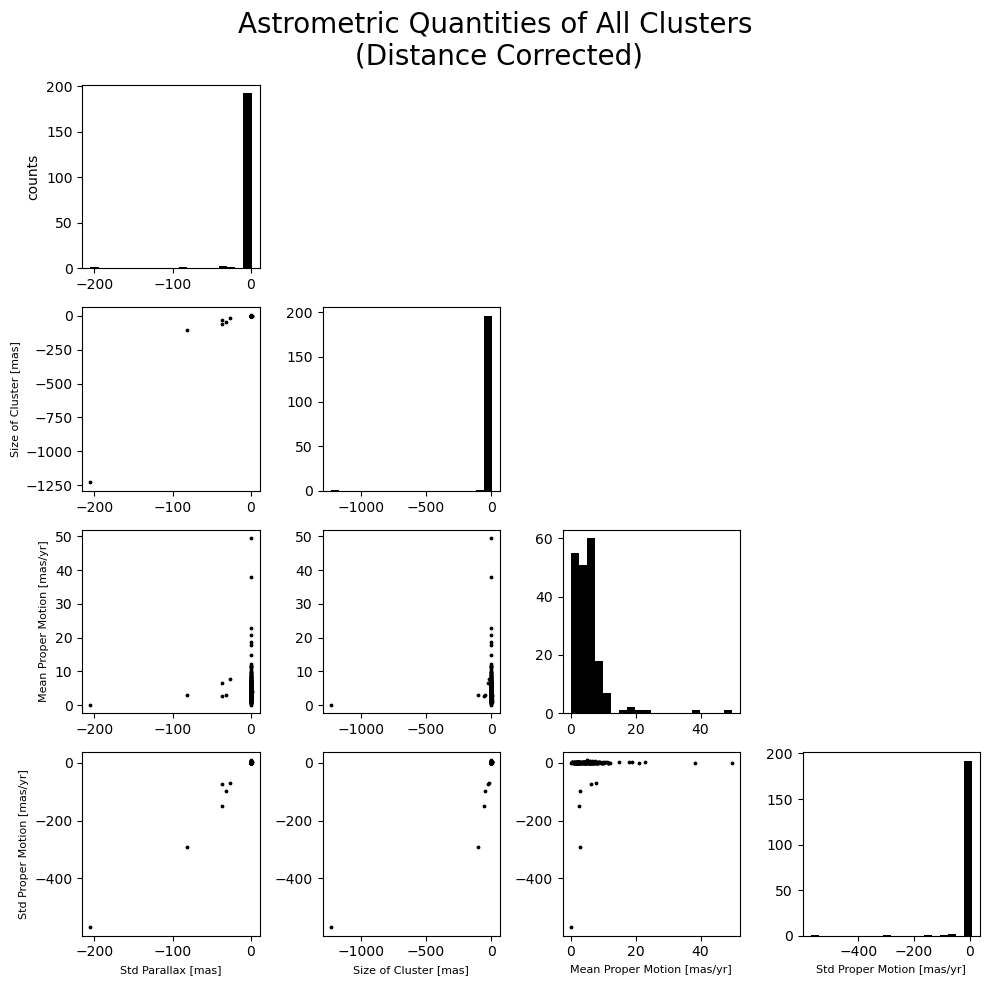

In [27]:
#Now we have to Plot, Compare and Show the Histrograms of the following:
    #1-) Std Parallax
    #2-) Size of Cluster
    #3-) Mean Proper Motion
    #4-) Std Proper Motion

#For this we define a function as follows. (Most of this is function is copied 
#from the code I wrote for Assignment 1)
def astrometric_quantity_corrected_plot(cluster_dataframe_corrected):
    """Takes the Cluster DataFrame. Returns the Scatter plots of the astrometric 
    quantities in 4-D Parameter Space alongside their histogram.
    
    Input:
    ----------------------------------------------------------------------------
    cluster_dataframe: Cluster DataFrame containing the Astrometic Quantities.
    
    Output:
    ----------------------------------------------------------------------------
    Scatter Plots & Histograms of the Astrometric Quantities in 4-D Parameter
    Space.
    
    """
    
    #We first define the labels we have, which are the Astrometric Quantities
    #we have on our DataFrame.
    labels = ["Std Parallax [mas]", "Size of Cluster [mas]", 
              "Mean Proper Motion [mas/yr]", "Std Proper Motion [mas/yr]"]
    
    #Now we horizontally stack all the columns we need by using np.column_stack!
    h_array = np.column_stack((cluster_dataframe_corrected["Std Parallax"],
                               cluster_dataframe_corrected["Size of Cluster"],
                               cluster_dataframe_corrected["Mean Proper Motion"],
                               cluster_dataframe_corrected["Std Proper Motion"]))
    
    #Since we will do a 4-D Scatter plot, our dimensions are defined as 4.
    num_dim = 4
    
    #Now we define the figures and the axes as follows.
    figure, axes = plt.subplots(num_dim, num_dim, figsize = (10, 10))
    
    #Now we adjust the figures so that the spacings are as we want.
    figure.subplots_adjust(wspace = 0.25, hspace = 0.35)
    
    #We add a label to our figure.
    figure.suptitle(f"Astrometric Quantities of All Clusters\n (Distance Corrected)", size = 20)
    
    #Now we do the following to get our plot grid.
    #Note that yellow is for high probability and black is for low probability.
    for i in range(num_dim): #y dimension of the grid.
        for j in range(num_dim): #x dimension of the grid
            if i == j: #For (0,0), (1,1), (2,2) etc.
                axes[i, j].hist(h_array[ : , i], bins = 20, color = "black")
                
        
            elif i > j: #For (0,1), (0,2), ... ,(1,2), ...
                axes[i, j].scatter(h_array[ : , j], h_array[ : , i], s = 3, c = "black")
        
            else:
                axes[i, j].axis("off")
        
            if j == 0: #For (0,1), (0,2) ...
                if i == j:
                    axes[i, j].set_ylabel("counts", fontsize = 10)
            
                else:
                    axes[i, j].set_ylabel(labels[i], fontsize = 8)
        
            if i == (num_dim - 1):
                axes[i, j].set_xlabel(labels[j], fontsize = 8)
    
    #To prevent plots clipping through one another we do the following.
    plt.tight_layout()

    #We show our plot.
    plt.show()

#We get our plots using the function.
astrometric_quantity_corrected_plot(cluster_dataframe_corrected)

C:\Users\kayah\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


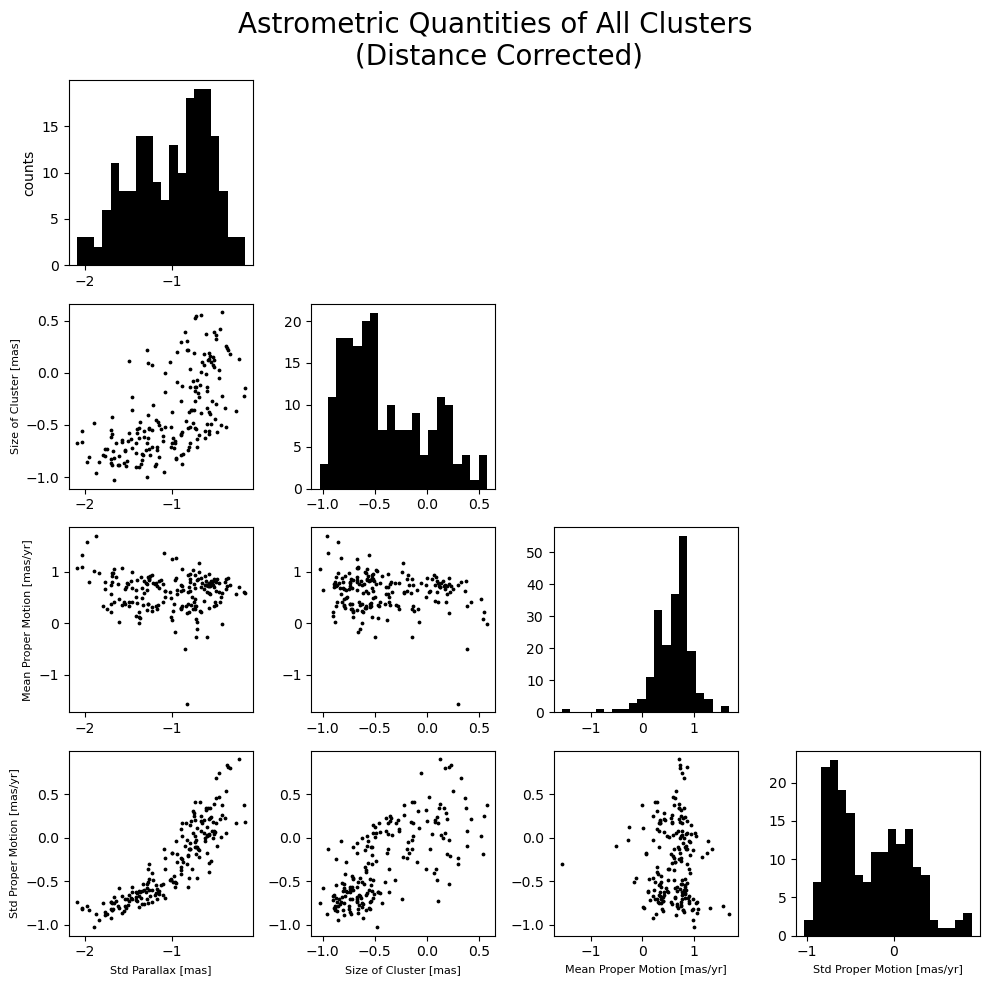

In [24]:
#Now we plot it in log-log scale to see the Correlations better.
cluster_dataframe_log_new = cluster_dataframe_corrected.copy()

#Now we define the columns/astrometric parameters that we want to take the
#logarithm of.
column_log_new = ["Std Parallax", "Size of Cluster", 
                  "Mean Proper Motion", "Std Proper Motion"]

#Now we take their logarithm.
cluster_dataframe_log_new[column_log_new] = np.log10(cluster_dataframe_log_new[column_log_new])

#We get our plots using the function.
astrometric_quantity_corrected_plot(cluster_dataframe_log_new)

In [25]:
#Finally, we do the Pearson and Spearman Correlation Tests as follows.
#To get the full sentences in "Pearson Test Result" & "Spearman Test Result"
def corr_coeff_calc_correct(cluster_dataframe_log_new):
    """Takes the Cluster DataFrame. Does the Pearson and Spearman Correlation 
    Tests and returns a DataFrame that contains the Correlation Coefficients and
    p-values from the Correlation Tests, alongside the information about the
    test results.
    
    Input:
    ----------------------------------------------------------------------------
    cluster_dataframe_log_new: Cluster DataFrame containing the Astrometic 
    Quantities.
    
    Output:
    ----------------------------------------------------------------------------
    corr_results_correct: DataFrame that contains all of the parameters we have 
    compared with their Correlation Coefficient and P-Values from Pearson and 
    Spearman Correlation Tests. The DataFrame also contains information on 
    whether the parameters have a correlation or not and how significant the 
    correlation is.
    
    """
    #First of all, let's create an empty Pandas DataFrame.
    corr_results = pd.DataFrame(columns = ["Compared Parameters", 
                                            "Pearson Corr Coeff",
                                            "Pearson p-value",
                                            "Pearson Test Result",
                                            "Spearman Corr Coeff",
                                            "Spearman p-value",
                                            "Spearman Test Result"])
    
    #We drop all the rows that have NaN values as follows.
    cluster_dataframe_log_new = cluster_dataframe_log_new.dropna(how = "any")
    
    #In this function we'll use another method to create a new Pandas DataFrame.
    #First of all, we define a list to store our Correlation Test Results.
    test_results = []
    
    #We now define the Astrometric Parameters that are in our DataFrame.
    labels = ["Std Parallax", "Size of Cluster", 
              "Mean Proper Motion", "Std Proper Motion"]
    
    #We first horizontally stack all the columns we need by using np.column_stack!
    h_array = np.column_stack((cluster_dataframe_log_new["Std Parallax"],
                               cluster_dataframe_log_new["Size of Cluster"],
                               cluster_dataframe_log_new["Mean Proper Motion"],
                               cluster_dataframe_log_new["Std Proper Motion"]))
    
    #Just like on the plotting, we'll again use slicing.
    #We again define the number of dimensions/parameters.
    num_dim = 4
    
    #Now we do a loop like we did it in plotting.
    #But this time, we'll get the Correlation Coefficients and p-values instead.
    for i in range(num_dim): #y dimension
        for j in range(num_dim): #x dimension
            #First, we have to do the tests.
            #For these tests, we'll have to skip the cases where i = j since
            #those correspond to histograms.
            #We do it with the following "if" statement.
            if i >= j:
                continue
            
            #We get our datasets i.e. our Astrometric Quantities.
            dataset_1 = h_array[ : , j]
            dataset_2 = h_array[ : , i]
                
            #Now we do our Correlation Tests.
            
            ############################## PEARSON TEST ##############################
            
            #We do the Pearson Correlation Test.
            pearson_corr_value, pearson_p_value = pearsonr(dataset_1, dataset_2)
            
            #We also comment on whether this result corresponds to a correlation
            #or not.
            #We have talked about this before this block of code so we just
            #write what we have discussed.
            
            #For Correlation Value:
            if pearson_corr_value >= 0.5:
                result_pearson_1 = "Strong Positive Correlation"
            
            elif 0 < pearson_corr_value < 0.5:
                result_pearson_1 = "Weak Positive Correlation"
            
            elif abs(pearson_corr_value) <= 0.09  or pearson_corr_value == 0:
                result_pearson_1 = "No Correlation"
            
            elif -0.5 < pearson_corr_value < 0:
                result_pearson_1 = "Weak Negative Correlation"
            
            elif pearson_corr_value <= -0.5:
                result_pearson_1 = "Strong Negative Correlation"
            
            #For p-value:
            if pearson_p_value <= 0.05:
                result_pearson_2 = "Statistically Significant"
            
            else:
                result_pearson_2 = "Statistically Not Significant"
            
            #Now we get our result.
            result_pearson = f"{result_pearson_1}, " \
                             f"{result_pearson_2}."
            
            ############################## SPEARMAN TEST #############################
            #We do the Spearman Correlation Test.
            spearman_corr_value, spearman_p_value = spearmanr(dataset_1, dataset_2)
            
            #We also comment on whether this result corresponds to a correlation
            #or not.
            #We have talked about this before this block of code so we just
            #write what we have discussed.
            
            #For Correlation Value:
            if spearman_corr_value >= 0.5:
                result_spearman_1 = "Strong Positive Correlation"
            
            elif 0 < spearman_corr_value < 0.5:
                result_spearman_1 = "Weak Positive Correlation"
            
            elif abs(spearman_corr_value) <= 0.09 or spearman_corr_value == 0:
                result_spearman_1 = "No Correlation"
            
            elif -0.5 < spearman_corr_value < 0:
                result_spearman_1 = "Weak Negative Correlation"
            
            elif spearman_corr_value <= -0.5:
                result_spearman_1 = "Strong Negative Correlation"
            
            #For p-value:
            if spearman_p_value <= 0.05:
                result_spearman_2 = "Statistically Significant"
            
            else:
                result_spearman_2 = "Statistically Not Significant"
            
            #Now we get our result.
            result_spearman = f"{result_spearman_1}, " \
                              f"{result_spearman_2}."
            
            #Second, we have to get the parameters we are comparing.
            parameter_1 = labels[i]
            parameter_2 = labels[j]
            
            #Now we add everything to our list.
            test_results.append({"Compared Parameters" : f"{parameter_1} vs {parameter_2}",
                                 "Pearson Corr Coeff" : pearson_corr_value,
                                 "Pearson p-value" : pearson_p_value,
                                 "Pearson Test Result": result_pearson,
                                 "Spearman Corr Coeff": spearman_corr_value,
                                 "Spearman p-value": spearman_p_value,
                                 "Spearman Test Result" : result_spearman})
    
    #Now we create a DataFrame using the test_results list as follows.
    corr_results_correct = pd.DataFrame(test_results)
    
    return corr_results_correct

#We do the following to expand the maximum column width.
pd.set_option('display.max_colwidth', None)

#Now we get our results.
corr_coeff_calc_correct(cluster_dataframe_log_new)

,Compared Parameters,Pearson Corr Coeff,Pearson p-value,Pearson Test Result,Spearman Corr Coeff,Spearman p-value,Spearman Test Result
0,Std Parallax vs Size of Cluster,0.610503,5.393046e-21,"Strong Positive Correlation, Statistically Significant.",0.663494,9.969436e-26,"Strong Positive Correlation, Statistically Significant."
1,Std Parallax vs Mean Proper Motion,-0.144028,4.625276e-02,"Weak Negative Correlation, Statistically Significant.",-0.073261,3.125600e-01,"No Correlation, Statistically Not Significant."
2,Std Parallax vs Std Proper Motion,0.881157,1.020960e-63,"Strong Positive Correlation, Statistically Significant.",0.916542,1.506442e-77,"Strong Positive Correlation, Statistically Significant."
3,Size of Cluster vs Mean Proper Motion,-0.174804,1.530698e-02,"Weak Negative Correlation, Statistically Significant.",-0.095365,1.882454e-01,"Weak Negative Correlation, Statistically Not Significant."
4,Size of Cluster vs Std Proper Motion,0.696875,3.071143e-29,"Strong Positive Correlation, Statistically Significant.",0.716506,1.540356e-31,"Strong Positive Correlation, Statistically Significant."
5,Mean Proper Motion vs Std Proper Motion,-0.034567,6.340820e-01,"No Correlation, Statistically Not Significant.",-0.065345,3.678558e-01,"No Correlation, Statistically Not Significant."


In [26]:
#We set the DataFrame option back to normal.
pd.reset_option('display.max_colwidth')

## Comments:

* The results of the Correlation Tests and their meanings are provided on the Table/DataFrame above.
* After doing the distance correction we can see that our Graphs and Correlation Test Results have changed.

* **Before the Distance Correction:**
    * 1-) **Std Parallax vs Size of Cluster:** 
        * **Pearson:** 
            * Weak Positive Correlation.
            * Statistically Significant.
        * **Spearman:** 
            * Weak Positive Correlation.
            * Statistically Significant.
    * 2-) **Std Parallax vs Mean Proper Motion:**
        * **Pearson:** 
            * No Correlation.
            * Statistically Not Significant.
        * **Spearman:** 
            * No Correlation.
            * Statistically Not Significant.
    * 3-) **Std Parallax vs Std Proper Motion:**
        * **Pearson:** 
            * Strong Positive Correlation.
            * Statistically Significant.
        * **Spearman:** 
            * Strong Positive Correlation.
            * Statistically Significant.
    * 4-) **Size of Cluster vs Mean Proper Motion:**
        * **Pearson:** 
            * No Correlation.
            * Statistically Not Significant.
        * **Spearman:** 
            * No Correlation.
            * Statistically Not Significant.
    * 5-) **Size of Cluster vs Std Proper Motion:**
        * **Pearson:** 
            * Strong Positive Correlation.
            * Statistically Significant.
        * **Spearman:** 
            * Strong Positive Correlation.
            * Statistically Significant.
    * 6-) **Mean Proper Motion vs Std Proper Motion:**
        * **Pearson:** 
            * Weak Positive Correlation.
            * Statistically Significant.
        * **Spearman:** 
            * Weak Positive Correlation.
            * Statistically Significant.

* **After the Distance Correction:** (***The changed results are printed like this***)
    * 1-) **Std Parallax vs Size of Cluster:** 
        * **Pearson:** 
            * ***Strong Positive Correlation.***
            * Statistically Significant.
        * **Spearman:** 
            * ***Strong Positive Correlation.***
            * Statistically Significant.
    * 2-) **Std Parallax vs Mean Proper Motion:**
        * **Pearson:** 
            * ***Weak Negative Correlation .***
            * ***Statistically Significant.***
        * **Spearman:** 
            * No Correlation.
            * Statistically Not Significant.
    * 3-) **Std Parallax vs Std Proper Motion:**
        * **Pearson:** 
            * Strong Positive Correlation.
            * Statistically Significant.
        * **Spearman:** 
            * Strong Positive Correlation.
            * Statistically Significant.
    * 4-) **Size of Cluster vs Mean Proper Motion:**
        * **Pearson:** 
            * ***Weak Negative Correlation.***
            * ***Statistically Significant.***
        * **Spearman:** 
            * ***Weak Negative Correlation.***
            * Statistically Not Significant.
    * 5-) **Size of Cluster vs Std Proper Motion:**
        * **Pearson:** 
            * Strong Positive Correlation.
            * Statistically Significant.
        * **Spearman:** 
            * Strong Positive Correlation.
            * Statistically Significant.
    * 6-) **Mean Proper Motion vs Std Proper Motion:**
        * **Pearson:** 
            * ***No Correlation.***
            * ***Statistically Not Significant.***
        * **Spearman:** 
            * ***No Correlation.***
            * ***Statistically Not Significant.***

* We see that the distance correction has revealed different correlations for our Astrometric Quantities.
* Some of our correlations have been confirmed more clearly.
* As for some of our other correlations, some of them turned out to be no correlations and some of them turned out to be weak correlations.

## Problems with the code:
* **Due to the Problems we had in Task 3 with the Realistic Distribution and us using that Distribution to calculate the distances to the clusters on Task 4, there are some problems that I came across.**
* **About 6 to 7 of the clusters have an absurd amount of negative distances, which again can be fixed by playing with the distance interval we have defined on Task 3.**
* **When using a different distance interval** (it is left as a comment on the Posterior_PDF function in task 3) **I managed to get all the distances positive except for one cluster so from there I found out the distance interval could be the reason why this is happening.** (Alongside the problem with the Realistic Distribution of course.)
* **Due to these negative values, although they are small amount of data compared to the rest of the data, our results have of course changed.**